<a href="https://colab.research.google.com/github/HEsiyun/nlp-project-draft/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Nov 29 23:04:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


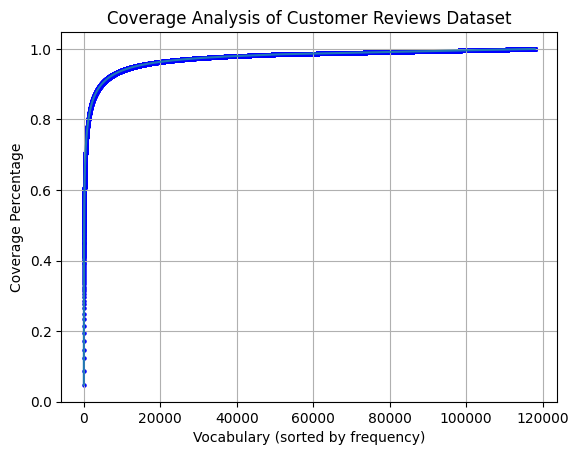

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
import numpy as np

nltk.download('punkt_tab')

# Read the CSV file into a DataFrame
df = pd.read_csv('data.csv')

# Tokenize words in each review
def word_token_counts(review):
    words = nltk.word_tokenize(str(review))
    return words

# Apply the function to get a list of words for each review in the sampled data
df['word_tokens'] = df['review_body'].apply(word_token_counts)

# Flatten the list of word tokens to get a single list of all words
all_words = [word for sublist in df['word_tokens'] for word in sublist]

# Calculate word frequency
word_freq = Counter(all_words)

# Rank the words by frequency
ranked_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Calculate the cumulative percentage of word coverage
total_words = sum(word_freq.values())
cumulative_coverage = np.cumsum([freq for _, freq in ranked_words]) / total_words

# Plot the results
plt.figure()

# Line plot
plt.plot(range(1, len(ranked_words) + 1), cumulative_coverage)

# Scatter plot to add points
plt.scatter(range(1, len(ranked_words) + 1), cumulative_coverage, color='blue', s=5)

plt.xlabel('Vocabulary (sorted by frequency)')
plt.ylabel('Coverage Percentage')
plt.title('Coverage Analysis of Customer Reviews Dataset')
plt.grid(True)

# show the plot
plt.show()

plt.close()

In [6]:
# calculate the vocabulary size of the data
vocab_size = len(word_freq)
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 117956


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load the dataset
df = pd.read_csv('data.csv')

# Split the data into features and labels
X = df['review_body'].values
y = df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Add more LSTM layers to increase model complexity
# model = Sequential([
#     Embedding(input_dim=10000, output_dim=64, input_length=max_length),
#     LSTM(64, return_sequences=True),
#     LSTM(64, return_sequences=True),
#     Dropout(0.3),
#     LSTM(32),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])


# # Build the LSTM model
# model = Sequential([
#     Embedding(input_dim=10000, output_dim=64, input_length=max_length),
#     LSTM(64, return_sequences=True),
#     Dropout(0.45),
#     LSTM(32),
#     Dropout(0.45),
#     Dense(1, activation='sigmoid')
# ])

# Use Bidirectional LSTM
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.00005)  # Default is 0.001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Num GPUs Available:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5361 - loss: 0.6890 - val_accuracy: 0.6506 - val_loss: 0.6343
Epoch 2/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7542 - loss: 0.5206 - val_accuracy: 0.8281 - val_loss: 0.3913
Epoch 3/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8478 - loss: 0.3627 - val_accuracy: 0.8336 - val_loss: 0.3670
Epoch 4/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8740 - loss: 0.3174 - val_accuracy: 0.8419 - val_loss: 0.3615
Epoch 5/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8901 - loss: 0.2881 - val_accuracy: 0.8441 - val_loss: 0.3675
Epoch 6/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9029 - loss: 0.2652 - val_accuracy: 0.8429 - val_loss: 0.3798
Epoch 7/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9131 - loss: 0.2449 - val_accuracy: 0.8405 - val_loss: 0.3960
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8327 - loss: 0.3824
Test Accuracy: 

272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


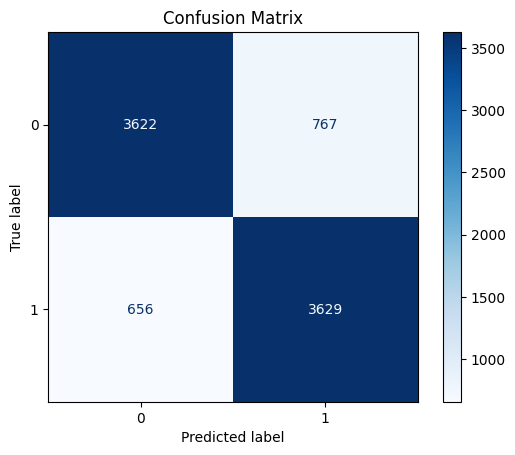

Precision: 0.83
Recall: 0.85


In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_prob = model.predict(X_test_padded)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print precision and recall
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

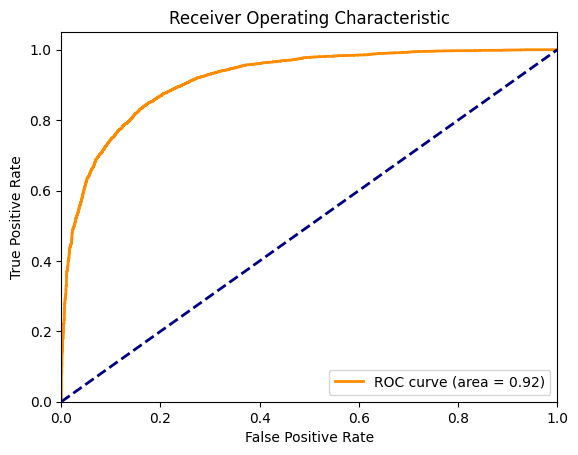

AUC: 0.92


In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f'AUC: {roc_auc:.2f}')